# Plots for the referees

In [1]:
reload = 0
import py21cmfast as p21c
import platform, time, os, h5py, shutil, matplotlib
import cosmo_tools as cosmo
import PyLab as PL
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams.update({
    'text.usetex': True,
    'font.family':'Times',
    'text.latex.preamble': r'\usepackage{newtxtext,newtxmath}'})
data_file = '/Users/cangtao/FileVault/LaTex/BoostFactor/Codes/v3/data/Boost_old.npz'
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Run LightCone

In [2]:
def RunP21c():
    HII_DIM = 100
    redshift = 11.0
    Z_HEAT_MAX = 60
    GLB_Quantities = ('brightness_temp','Ts_box','xH_box','Tk_box', 'Boost_box', 'density')
    LC_Quantities = ('brightness_temp','Ts_box','xH_box','Tk_box')
    INHOMO_HALO_BOOST = True
    FileName = '/Users/cangtao/Desktop/tmp.h5'
    user_params = p21c.UserParams(
        HII_DIM = HII_DIM,
        N_THREADS = 1,
        USE_RELATIVE_VELOCITIES = False,
        USE_INTERPOLATION_TABLES = True,
        FAST_FCOLL_TABLES = False,
        HMF = 1,
        POWER_SPECTRUM = 2,
        DM_Dep_Method = 1,
        DM_ANN_Channel = 1,
        BOX_LEN = 500)
    astro_params = p21c.AstroParams(
        Pann27 = 0.0,
        mdm = 1,
        L_X = 40.5,
        F_STAR10 = -1.3,
        ALPHA_STAR = 0.5,
        F_ESC10 = -1.0,
        ALPHA_ESC = -0.5,
        M_TURN = 8.7,
        t_STAR = 0.5,
        NU_X_THRESH = 500.0)
  
    flag_options = p21c.FlagOptions(
        USE_MINI_HALOS = False,
        USE_MASS_DEPENDENT_ZETA = True,
        INHOMO_RECO = True,
        USE_TS_FLUCT = True,
        USE_HALO_BOOST = True,
        PHOTON_CONS = True,
        INHOMO_HALO_BOOST = INHOMO_HALO_BOOST)

    start_time = time.time()
    InitialCondition = PL.HyRec(Pann = 0, Use_SSCK = 0, mdm = 1, DM_Channel=1)
    z = InitialCondition['z'][::-1]
    xe = InitialCondition['xe'][::-1]
    Tk = InitialCondition['Tk'][::-1]

    XION_at_Z_HEAT_MAX = np.interp(x = Z_HEAT_MAX, xp = z, fp = xe)
    XION_at_Z_HEAT_MAX = XION_at_Z_HEAT_MAX/(1+0.08112582781456953) # Convert to p21c format assuming shared xe, 0.08 is fHe
    TK_at_Z_HEAT_MAX = np.interp(x = Z_HEAT_MAX, xp = z, fp = Tk)
    with p21c.global_params.use(Z_HEAT_MAX = Z_HEAT_MAX, XION_at_Z_HEAT_MAX = XION_at_Z_HEAT_MAX, TK_at_Z_HEAT_MAX = TK_at_Z_HEAT_MAX):
        lc = p21c.run_lightcone(
            redshift=redshift, 
            max_redshift=Z_HEAT_MAX,
            astro_params=astro_params, 
            flag_options=flag_options,
            user_params = user_params,
            lightcone_quantities=LC_Quantities,
            global_quantities=GLB_Quantities,
            random_seed = 42)
    if os.path.exists(FileName):os.remove(FileName)
    end_time = time.time()
    print("Run time: {:.2f}".format(end_time - start_time))
    z = lc.node_redshifts
    Boost = lc.global_Boost
    np.savez(data_file, z = z, Boost = Boost)
    os.remove(FileName)
    
if reload: RunP21c()


# Plot boost for Referee

-16.968603949882485


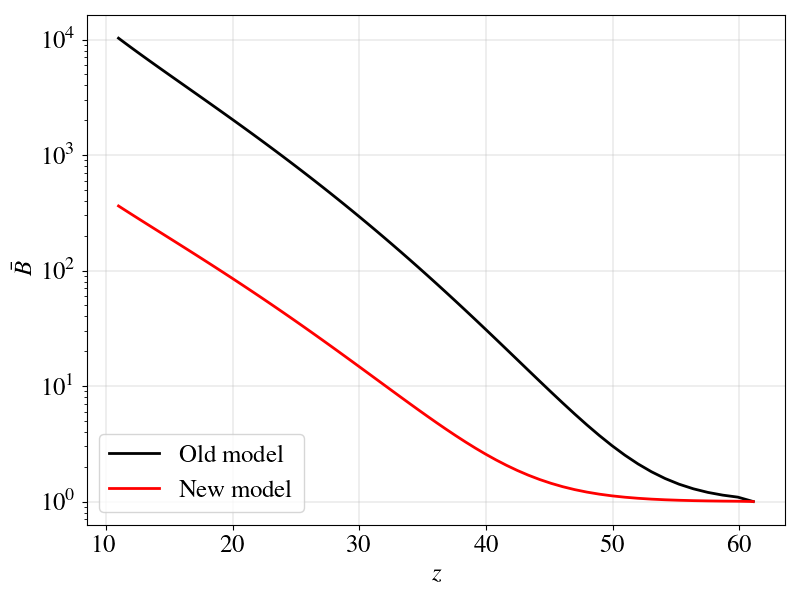

In [8]:
def Plot_Boost():
    LineWidth = 2
    FontSize = 18

    with np.load(data_file) as d:
        z0, b0 = d['z'], d['Boost']
    lc = p21c.LightCone.read('/Users/cangtao/Desktop/21cmFAST-data/BoostFactor_v3/IHM.h5')
    z1 = lc.node_redshifts
    b1 = lc.global_Boost
    
    fig, ax = plt.subplots()
    ax.grid(True, which='major', linewidth = 0.3)  # `which='both'` enables major and minor grids
    fig.set_size_inches(8, 6)
    plt.semilogy(z0, b0, 'k', linewidth=LineWidth, label = 'Old model')
    plt.semilogy(z1, b1, 'r', linewidth=LineWidth, label = 'New model')
    plt.xlabel('$z$',fontsize=FontSize,fontname='Times New Roman')
    plt.ylabel('$\\bar{B}$',fontsize=FontSize,fontname='Times New Roman')
    plt.xticks(size=FontSize)
    plt.yticks(size=FontSize)
    plt.legend(fontsize=FontSize,loc = 'lower left')
    plt.tight_layout()
    plt.savefig('/Users/cangtao/Desktop/Referee_boost_difs.pdf')
    print(np.mean(1-b0/b1))

Plot_Boost()

Comoving length scale for z resolution used in Tracy paper

2.697514589467849


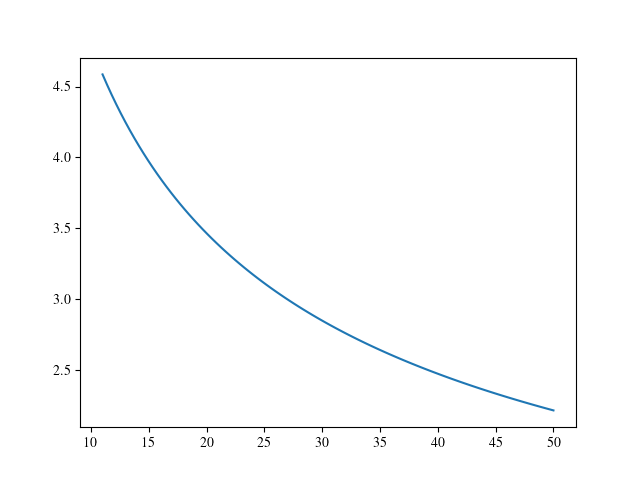

In [20]:
dlzp = 0.002
z = np.linspace(11, 50, 100)
c = 299792458
H = PL.Hubble(z=z)
dx = dlzp * c * (1+z)/H
Mpc = 3.086E22
dx = dx / Mpc

fig, ax = plt.subplots()
plt.plot(z, dx)

# dx = dx[0]
print(dx[0]/1.7)